## Disclaimer: 

Code, type hints and some comments were generated by ChatGPT

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

# Layers

Layer is a unit in the network that transforms input data into some output -> kind of processing function inside of the network.

In [ ]:
# Super class for NN layer, must have atlest forward passing and backward propagation
class Layer:
    # process input to output
    def forward(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    # process gradient during backward prop
    def backward(self, grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    # return learning parameters if any
    def params(self) -> List[Tuple[np.ndarray, np.ndarray]]:
        return []

Some of the layers have learnable parameters. These parameters are weights and biases and we need to return them to optimizer so it can update them.
Example of such layer is Dense. It is a fully connected layer meaning that every node of the previous layer is connected to every node of current layer. Forward pass in this case simply multiplies X by weights and adds biases. Backward pass is way more complicated especiailly if you are trying to solve it without matrix multiplaction as we can see in second nn_math_class_example notebook. What it does is computes gradients for weights and biases, propagates them backward to the previous layer and lets the optimizer to upate weights and biases using gradient descent.

Good analogy from ChatGPT:

- Forward pass: “compute the output from input and current weights.”

- Backward pass: “tell each weight and bias how it should change to reduce the loss, and pass the rest of the error backward.”

About matrices in backward propagation:
Without the matrices it is surprisingly hard and time co nsuming to do. Especially if you don't have a fixed amount of layers and nodes and want it to be more or less flexible. But using matrices simplifies the code a lot:

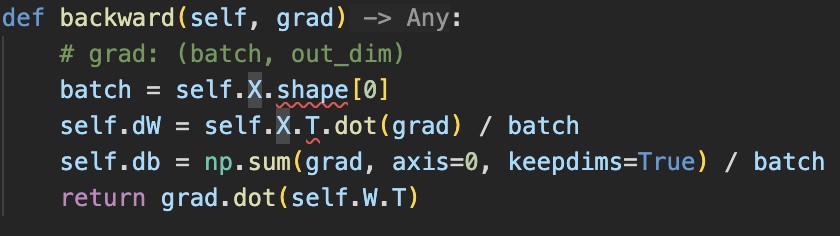




So, the backpropagation is the heart of learning in neural networks. But how it works in our example?

1. We calculate the gradient of the loss function. Great intuitive exaplantaion of what gradient is: https://www.youtube.com/watch?v=H1DJjyDFalw. If we imagine that our data is in 3D, gradient would the 2D vector that points direction to the highest point of our surface. However, in this case we are calculating gradient of loss function (which we want to minimize) and as I understand we are using negative gradient which points us the direction to the lowest loss function value. In this example Stochastic Gradient Descent is used meaning that we are using only random part of the data at time. SGD: https://www.youtube.com/watch?v=UmathvAKj802
2. We store the number of samples in the batch in order to average the gradients so that learning rate doesn't depend on batch size
3. Then we compute dW which is gradient of the weights W. We take the transpose matrix of our inputs X and perform dot multiplication with grad (gradient of the current layer output) and divide by batch number to get average value. All this tells each node in the layer how they should change own weight
4. We perform same for biases, but in this case we use sum function as biases are additive
5. Then we return a gradient of the loss with respect to the inputs of the layer. Since we are going backwards, this is passed to previous layer and used as "grad" variable or the gradient of output. Previous layer output <- Current layer input

What are weight initialization methods?
If we set all initial weights to zero it will cause symmetry - every neuron will learn the same thing. But if use completly random weights, it might cause vanishing or exploding gradients. So they designed different methods for different activation function. In this example we have Xavier initialization and He.

![Screenshot 2025-10-01 at 15.41.39.png](<attachment:Screenshot 2025-10-01 at 15.41.39.png>)


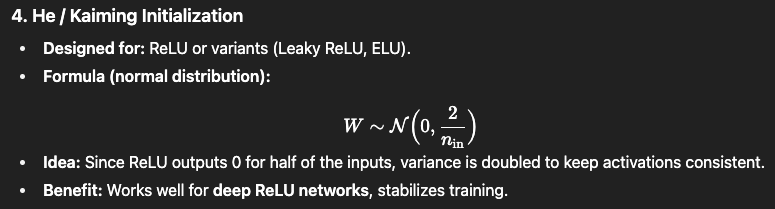
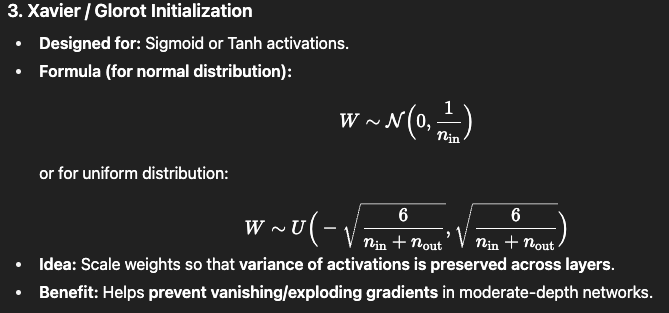

In [ ]:
class Dense(Layer):
    def __init__(self, in_dim: int, out_dim: int, weight_init: str = "he") -> None:
        """
        Fully connected (dense) layer.
        
        Args:
            in_dim (int): Number of input features per sample.
            out_dim (int): Number of output features per sample.
            weight_init (str): Weight initialization method. Options: "he", "xavier", "normal".
        """
        self.in_dim: int = in_dim
        self.out_dim: int = out_dim

        # Initialize weights based on the chosen method
        if weight_init == "he":
            # He initialization for ReLU activations
            self.W: np.ndarray = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)
        elif weight_init == "xavier":
            # Xavier/Glorot initialization for tanh/sigmoid activations
            self.W: np.ndarray = np.random.randn(in_dim, out_dim) * np.sqrt(1.0 / in_dim)
        else:
            # Standard normal small initialization
            self.W: np.ndarray = np.random.randn(in_dim, out_dim) * 0.01

        # Initialize biases to zeros
        self.b: np.ndarray = np.zeros((1, out_dim))

        # Gradients placeholders (same shape as parameters)
        self.dW: np.ndarray = np.zeros_like(self.W)
        self.db: np.ndarray = np.zeros_like(self.b)

        # Cache input for backward pass
        self.X: np.ndarray | None = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass of the dense layer.
        
        Args:
            X (np.ndarray): Input data of shape (batch_size, in_dim)
        
        Returns:
            np.ndarray: Output of shape (batch_size, out_dim)
        """
        # Cache input for backward pass
        self.X = X
        # Linear transformation
        return X.dot(self.W) + self.b

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """
        Backward pass of the dense layer. Computes gradients w.r.t. weights, biases, and inputs.
        
        Args:
            grad (np.ndarray): Gradient of the loss w.r.t. layer output, shape (batch_size, out_dim)
        
        Returns:
            np.ndarray: Gradient of the loss w.r.t. layer input, shape (batch_size, in_dim)
        """
        batch: int = self.X.shape[0]

        # Gradient w.r.t. weights
        self.dW = self.X.T.dot(grad) / batch
        # Gradient w.r.t. biases
        self.db = np.sum(grad, axis=0, keepdims=True) / batch
        # Gradient w.r.t. inputs (to propagate to previous layer)
        return grad.dot(self.W.T)

    def params(self) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Returns the parameters and their corresponding gradients.
        
        Returns:
            List of tuples: [(weights, weight_grad), (biases, bias_grad)]
        """
        return [(self.W, self.dW), (self.b, self.db)]


Then there are some layers that doesn't return any learnable parameters. They just process the input data to the output. For example ReLu:

In [50]:
class ReLU(Layer):
    def __init__(self):
        self.mask = None
    def forward(self, X):
        self.mask = (X > 0)
        return X * self.mask
    def backward(self, grad):
        return grad * self.mask

ReLu's forward pass keeps only positive values - self.mask is a boolean array, where positive values are masked as True and negative as False. When we multiply the data by it's mask, under the hood booleana are just integers 1 and 0. So the negative values are multiplied by 0 and become zero, while positive don't change at all. 

In the backward pass, for all neurons where data is positive, we let the gradient flow, and for negative data we "block" the neuron by zeroing the gradient.

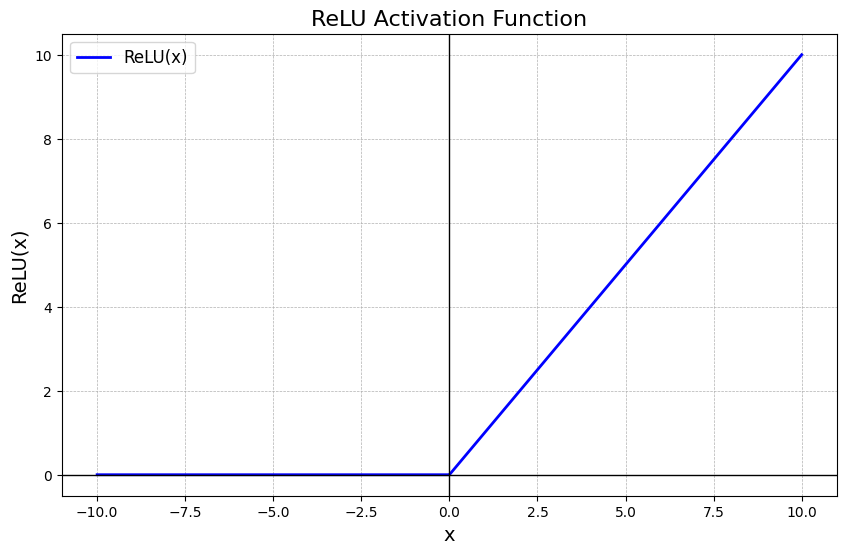

Sigmoid layer is another classic activation function

In [51]:
class Sigmoid(Layer):
    def __init__(self):
        self.out = None
    def forward(self, X):
        self.out = 1 / (1 + np.exp(-X))
        return self.out
    def backward(self, grad):
        return grad * (self.out * (1 - self.out))

Sigmoid function "squeezes" values between 0 and 1, where:

Small or negative inputs → outputs close to 0.

Large positive inputs → outputs close to 1.

Values around 0 get mapped near 0.5.


By that squeezing, we make the network nonlinear and this behaviour is useful for things like probabilities in binary classification. As the output could be interpreted as a probability (e.g. 0.8 = 80% chance of being positive class), sigmoid is commonly used as a final layer in the network.


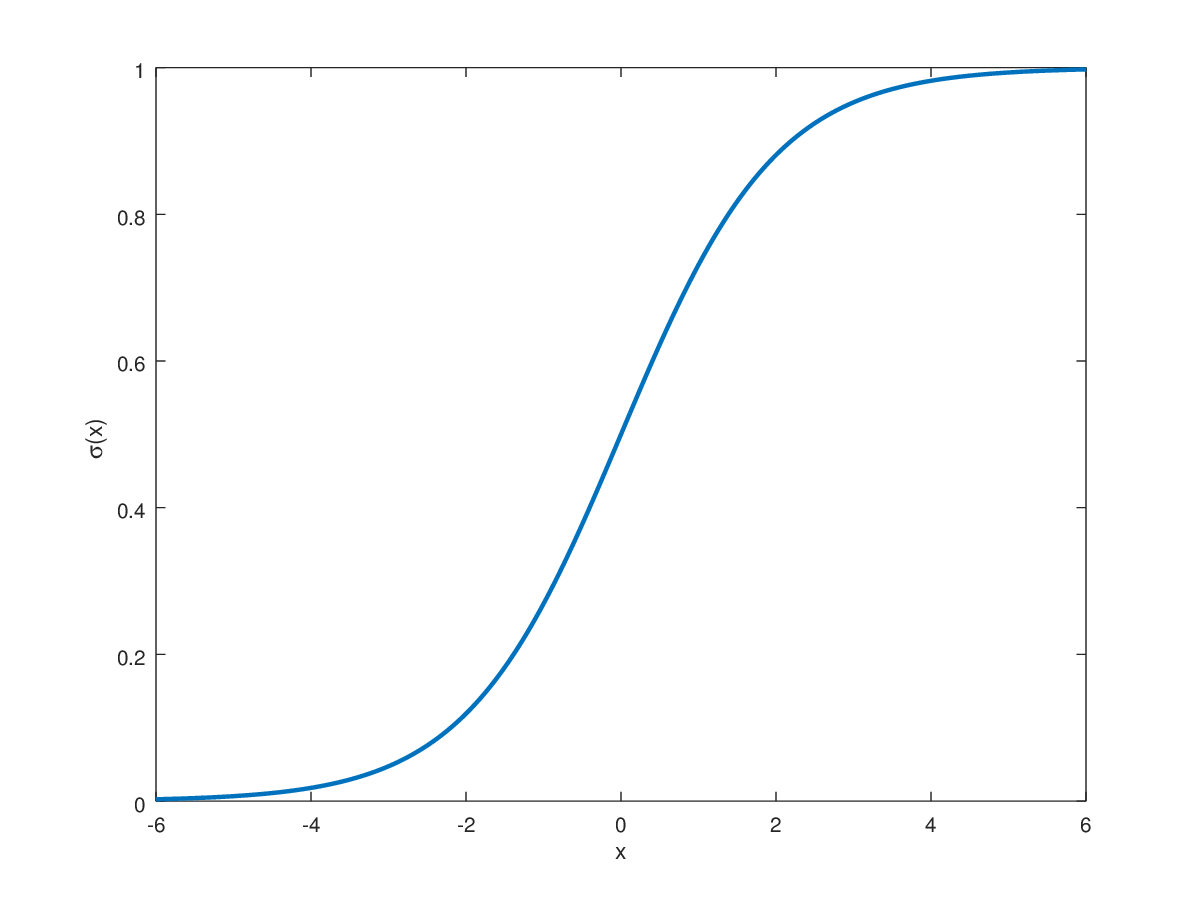

In [52]:
class Tanh(Layer):
    def __init__(self):
        self.out = None
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    def backward(self, grad):
        return grad * (1 - self.out ** 2)

Tanh function is a relative to sigmoid, but with few differences. It maps the value into the range from -1 to 1, where:

Negative inputs → outputs close to -1

Positive inputs → outputs close to +1

Input 0 → output 0


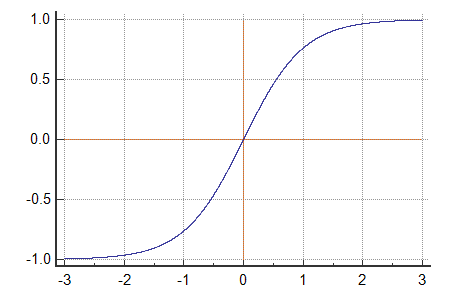

In this case, tanh function output cannot be interpreted as probability anymore. So, it's not usually used as the final output. Instead, it's sometimes used in hidden layers of RNNs or LSTMs because being zero-centered and symmetric helps optimization. But in common, ReLu is often preferred due to faster training.

Softamax layer is a usual choice for multi-class classification problems:

In [53]:
class Softmax(Layer):
    # Note: combined with cross-entropy loss gives a simpler gradient.
    def __init__(self):
        self.out = None
    def forward(self, X):
        X = X - np.max(X, axis=1, keepdims=True)
        exp = np.exp(X)
        self.out = exp / np.sum(exp, axis=1, keepdims=True)
        return self.out
    def backward(self, grad):
        # grad is (batch, classes) coming from loss
        # For numeric stability, assume grad already computed correctly
        # If using cross-entropy + softmax, one should call loss.grad that takes them into account
        return grad

It converts raw scores (called also logits) into probabilities:

The biggest logit gets the biggest probability.

The outputs are always between (0,1).

Probabilities sum to 1 → interpretable as categorical probabilities.

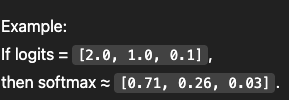
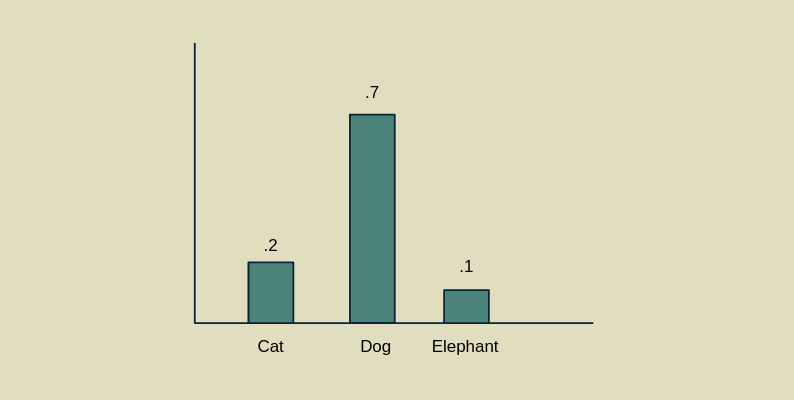

# Losses

Loss functions general purpose is to tell how wrong is the prediction. It measures difference between real value and estimated, therefore if prediction is far from real value -> high loss. In other words it also can be called the signal that tells the models how to improve.

Loss function is highly connected with gradient, as loss function generates the gradient and gradient is the core of learning:
1. Compute loss function
2. Compute the gradient of the loss -> tells the direction and magnitude to adjust each weight to reduce the loss
3. Update the weights

So, in our case, every loss function must do calculation of the error (self.__call__) and gradient with respect to predictions (self.grad):

In [54]:
class Loss:
    def __call__(self, y_pred, y_true):
        raise NotImplementedError
    def grad(self, y_pred, y_true):
        raise NotImplementedError

There are different loss function and choice of which one to use is closely related with the activation function in the output layer (nature of the problem one tries to solve)

MSE or Mean Squared Error is commonly used fot regression tasks. It measures the average square difference between predictions and true values. Mathematically it:
1. Counts the difference between real and predicted value
2. Squares it. Main purpose of using square is to enforce bigger punishment for bigger errors and smaller for smaller. If you your real value is 10 and model predicts 1000 you want it to react faster and change weights more aggresivly than if prediction is 15. Also squaring simplifies some math.
3. Multiply by 0.5. This is optional as it doesn't change the general outcome but is convinient for gradient computation (again simplifies some maths under the hood)
4. Take the average of the result. As we process everything in batches, we need to take average over all samples in the batch

And after that, to compute gradient we simply take the difference and divide by number of samples. If prediction is greater than true value, gradient is positive and we need to decrease prediction and vice versa

MSE is used for regression problems and works well with Linear Output, so we don't need to use any special output layer.

In [55]:
class MSE(Loss):
    def __call__(self, y_pred, y_true):
        return np.mean(0.5 * (y_pred - y_true) ** 2)
    def grad(self, y_pred, y_true):
        batch = y_true.shape[0]
        return (y_pred - y_true) / batch

In [56]:
class CrossEntropy(Loss):
    def __call__(self, y_pred, y_true):
        # y_pred: probabilities (after softmax)
        # y_true: either one-hot or integer labels
        eps = 1e-12
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            # integer labels
            y_true = y_true.reshape(-1)
            probs = np.clip(y_pred[range(len(y_pred)), y_true], eps, 1.0)
            return -np.mean(np.log(probs))
        else:
            # one-hot
            probs = np.clip(y_pred, eps, 1.0)
            return -np.mean(np.sum(y_true * np.log(probs), axis=1))
        
    def grad(self, y_pred, y_true):
        batch = y_pred.shape[0]
        # If y_true are integer labels, convert to one-hot
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            y_true = y_true.reshape(-1)
            grad = y_pred.copy()
            grad[range(batch), y_true] -= 1
            return grad / batch
        else:
            return (y_pred - y_true) / batch

# Optimizer

In [57]:
class SGD:
    def __init__(self, lr=0.01, momentum=0.0, l2=0.0):
        self.lr = lr
        self.momentum = momentum
        self.l2 = l2
        # velocity per parameter (list of arrays matching params)
        self.velocity = None


    def step(self, params):
    # params: list of tuples (param_array, grad_array)
        if self.velocity is None:
            self.velocity = [np.zeros_like(p[0]) for p in params]
        for i, (p, g) in enumerate(params):
            # add L2 regularization to gradient (weight decay)
            if self.l2 != 0 and p.ndim != 1: # skip biases
                g = g + self.l2 * p
            v = self.velocity[i]
            v[...] = self.momentum * v - self.lr * g
            p += v


    def set_lr(self, new_lr):
        self.lr = new_lr

# Neural Network

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.history = {"loss": [], "lr": []}

    def add(self, layer):
        self.layers.append(layer)

    def set_loss(self, loss):
        self.loss = loss


    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def backward(self, loss_grad):
        grad = loss_grad
        # Propagate through layers in reverse
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def params(self):
        # flatten all param tuples
        params = []
        for layer in self.layers:
            params.extend(layer.params())
        return params
    
    def predict(self, X):
        out = self.forward(X)
        # if last layer is Softmax, return class indices
        if isinstance(self.layers[-1], Softmax):
            return np.argmax(out, axis=1)
        return out
    
    def evaluate(self, X, y):
        y_pred = self.forward(X)
        loss_val = self.loss(y_pred, y)
        return loss_val
    
    def fit(self, X, y, epochs=10, batch_size=32, verbose=True, lr_schedule=None):
        # lr_schedule: function(epoch) -> lr
        n_samples = X.shape[0]
        for epoch in range(1, epochs + 1):
            # learning rate schedule
            if lr_schedule is not None:
                new_lr = lr_schedule(epoch)
                self.optimizer.set_lr(new_lr)
        # shuffle
            perm = np.random.permutation(n_samples)
            X_sh = X[perm]
            y_sh = y[perm]
            epoch_loss = 0.0
            for i in range(0, n_samples, batch_size):
                xb = X_sh[i:i+batch_size]
                yb = y_sh[i:i+batch_size]
                # forward
                out = self.forward(xb)
                loss_val = self.loss(out, yb)
                epoch_loss += loss_val * xb.shape[0]
                # gradient of loss wrt predictions
                if isinstance(self.loss, CrossEntropy) and isinstance(self.layers[-1], Softmax):
                    grad = self.loss.grad(out, yb) # combined, okay
                else:
                    grad = self.loss.grad(out, yb)
                # backward
                self.backward(grad)
                # update params
                self.optimizer.step(self.params())
                epoch_loss /= n_samples
                self.history["loss"].append(epoch_loss)
                self.history["lr"].append(self.optimizer.lr)
            if verbose:
                print(f"Epoch {epoch}/{epochs} - loss: {epoch_loss:.6f} - lr: {self.optimizer.lr:.6f}")

    def plot_learning_rate_and_loss(self):
        plt.plot(self.history["loss"])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

        plt.plot(self.history["lr"])
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate")
        plt.show()

# Example

In [59]:
# Tiny dataset: XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]])


nn = NeuralNetwork()
nn.add(Dense(2, 8))
nn.add(Tanh())
nn.add(Dense(8, 1))
nn.add(Sigmoid())


nn.set_loss(MSE())
nn.set_optimizer(SGD(lr=0.5, momentum=0.9, l2=0.0001))


nn.fit(X, y, epochs=1000, batch_size=4, verbose=True, lr_schedule=lambda e: 0.5 * (0.99 ** e))


preds = nn.predict(X)
print("Predictions (rounded):", np.round(nn.forward(X)))
print("Raw predictions:", nn.forward(X))
print("Class preds:", preds)

Epoch 1/1000 - loss: 0.130837 - lr: 0.495000
Epoch 2/1000 - loss: 0.130374 - lr: 0.490050
Epoch 3/1000 - loss: 0.129506 - lr: 0.485150
Epoch 4/1000 - loss: 0.128297 - lr: 0.480298
Epoch 5/1000 - loss: 0.126806 - lr: 0.475495
Epoch 6/1000 - loss: 0.125096 - lr: 0.470740
Epoch 7/1000 - loss: 0.123228 - lr: 0.466033
Epoch 8/1000 - loss: 0.121262 - lr: 0.461372
Epoch 9/1000 - loss: 0.119252 - lr: 0.456759
Epoch 10/1000 - loss: 0.117250 - lr: 0.452191
Epoch 11/1000 - loss: 0.115297 - lr: 0.447669
Epoch 12/1000 - loss: 0.113428 - lr: 0.443192
Epoch 13/1000 - loss: 0.111666 - lr: 0.438761
Epoch 14/1000 - loss: 0.110022 - lr: 0.434373
Epoch 15/1000 - loss: 0.108499 - lr: 0.430029
Epoch 16/1000 - loss: 0.107090 - lr: 0.425729
Epoch 17/1000 - loss: 0.105780 - lr: 0.421472
Epoch 18/1000 - loss: 0.104551 - lr: 0.417257
Epoch 19/1000 - loss: 0.103385 - lr: 0.413084
Epoch 20/1000 - loss: 0.102259 - lr: 0.408953
Epoch 21/1000 - loss: 0.101157 - lr: 0.404864
Epoch 22/1000 - loss: 0.100063 - lr: 0.4008

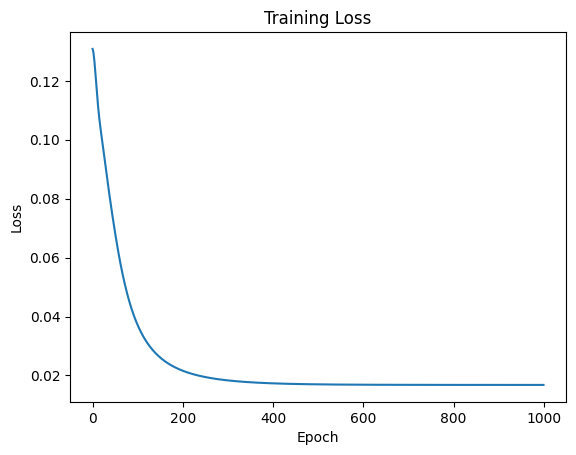

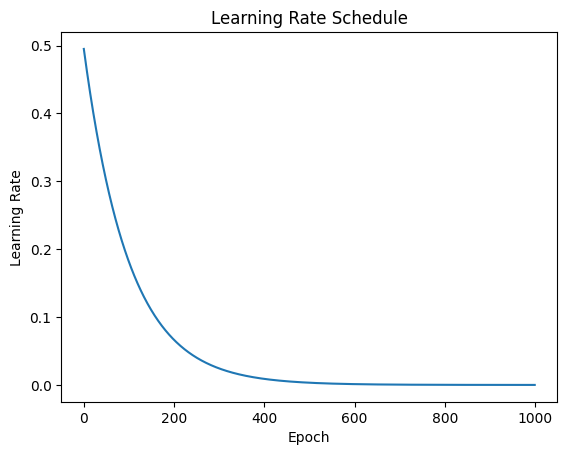

In [60]:
nn.plot_learning_rate_and_loss()